# Power vs. Dimension for 14 Relationships - Supplement

In [1]:
import glob
import math
import os, sys
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from joblib import Parallel, delayed, dump, load
from matplotlib.legend import Legend
from matplotlib.ticker import ScalarFormatter
from scipy.stats import entropy, norm, mstats
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier

from hyppo.independence import Dcorr
from hyppo.ksample import k_sample_transform
from sktree.ensemble import HonestForestClassifier
from sktree.stats import FeatureImportanceForestClassifier

from simulations import *

sys.path.append(os.path.realpath('..'))

In [2]:
from scipy.stats import multivariate_normal, entropy
from scipy.integrate import nquad


def make_trunk_classification(
    n_samples,
    n_dim=4096,
    n_informative=1,
    simulation: str = "trunk",
    mu_0: float = 0,
    mu_1: float = 1,
    rho: int = 0,
    band_type: str = "ma",
    return_params: bool = False,
    mix: float = 0.5,
    seed=None,
):
    if n_dim < n_informative:
        raise ValueError(
            f"Number of informative dimensions {n_informative} must be less than number "
            f"of dimensions, {n_dim}"
        )
    rng = np.random.default_rng(seed=seed)

    mu_0 = np.array([mu_0 / np.sqrt(i) for i in range(1, n_informative + 1)])
    mu_1 = np.array([mu_1 / np.sqrt(i) for i in range(1, n_informative + 1)])

    if rho != 0:
        if band_type == "ma":
            cov = _moving_avg_cov(n_informative, rho)
        elif band_type == "ar":
            cov = _autoregressive_cov(n_informative, rho)
        else:
            raise ValueError(f'Band type {band_type} must be one of "ma", or "ar".')
    else:
        cov = np.identity(n_informative)

    if mix < 0 or mix > 1:
        raise ValueError("Mix must be between 0 and 1.")

    # speed up computations for large multivariate normal matrix with SVD approximation
    if n_informative > 1000:
        method = "cholesky"
    else:
        method = "svd"

    if simulation == "trunk":
        X = np.vstack(
            (
                rng.multivariate_normal(mu_0, cov, n_samples // 2, method=method),
                rng.multivariate_normal(mu_1, cov, n_samples // 2, method=method),
            )
        )
    elif simulation == "trunk_overlap":
        mixture_idx = rng.choice(2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix])
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )
        X_mixture_2 = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )

        X = np.vstack(
            (
                X_mixture_2.reshape(n_samples // 2, n_informative),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    elif simulation == "trunk_mix":
        mixture_idx = rng.choice(2, n_samples // 2, replace=True, shuffle=True, p=[mix, 1 - mix])
        norm_params = [[mu_0, cov], [mu_1, cov]]
        X_mixture = np.fromiter(
            (
                rng.multivariate_normal(*(norm_params[i]), size=1, method=method)
                for i in mixture_idx
            ),
            dtype=np.dtype((float, n_informative)),
        )

        X = np.vstack(
            (
                rng.multivariate_normal(
                    np.zeros(n_informative), cov, n_samples // 2, method=method
                ),
                X_mixture.reshape(n_samples // 2, n_informative),
            )
        )
    else:
        raise ValueError(
            f"Simulation must be: trunk, trunk_overlap, trunk_mix"
        )

    if n_dim > n_informative:
        X = np.hstack((X, rng.normal(loc=0, scale=1, size=(X.shape[0], n_dim - n_informative))))

    y = np.concatenate((np.zeros(n_samples // 2), np.ones(n_samples // 2)))

    if return_params:
        returns = [X, y]
        if simulation == "trunk":
            returns += [[mu_0, mu_1], [cov, cov]]
        elif simulation == "trunk-overlap":
            returns += [[np.zeros(n_informative), np.zeros(n_informative)], [cov, cov]]
        elif simulation == "trunk-mix":
            returns += [*list(zip(*norm_params)), X_mixture]
        return returns
    return X, y

In [3]:
class Dcorr_PCA:
    def test(self, x, y):
        n_components = 'mle'
        x_pca = PCA(n_components=n_components).fit_transform(x)
        return Dcorr().test(x_pca, y)

In [1]:
class hypoRF:
    def __init__(self, n_estimators=2000):
        self.n_estimators = n_estimators

    def statistic(self, X, y):
        clf = RandomForestClassifier(n_estimators=self.n_estimators, oob_score=True)
        clf.fit(X, y)
        oob_error = 1 - clf.oob_score_
        return oob_error

In [5]:
sns.set_theme(color_codes=True, style='ticks', context='talk', font_scale=1.5)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[2:5] + PALETTE[6:], n_colors=9)

# SAMP_SIZES = [1024]
DIMENSIONS = [2**i for i in range(2, 13)]
SAMP_SIZE = 4096
REPS = range(1000)

SAVE_PATH = "n-{}_p-{}_{}".format(int(SAMP_SIZE), int(DIMENSIONS[0]), int(DIMENSIONS[-1]))
FIG_PATH = "figs"

SIMULATIONS = {
    "Linear": {"simulation" : "trunk"},
    "Nonlinear": {"simulation" : "trunk_mix", "mu_1" : 5, "mix" : 0.75},
    "Independent": {"simulation" : "trunk_overlap", "mu_1" : 5, "mix" : 0.75},
}

TESTS = {
    # "Dcorr" : Dcorr(),
    # "Dcorr_PCA" : Dcorr_PCA(),
    "hypoRF" : hypoRF(),
}

In [4]:
def _indep_sim_gen(X, p):
    """
    Generate x, y from each sim
    """
    X_t = X[:, :p]
    y_t = np.concatenate((np.zeros(4096 // 2), np.ones(4096 // 2)))
    return X_t, y_t


def _perm_stat(est, X, p=4096):
    """
    Generates null and alternate distributions
    """
    X, y = _indep_sim_gen(X, p)
    obs_stat = est.statistic(X, y)
    permy = np.random.permutation(y)
    perm_stat = est.statistic(X, permy)

    return obs_stat, perm_stat


def _nonperm_pval(est, X, p=4096):
    """
    Generates fast  permutation pvalues
    """
    X, y = _indep_sim_gen(X, p)
    pvalue = est.test(X, y)[1]
    return pvalue

In [6]:
def compute_null(rep, est, est_name, sim, n=100, p=1, **sim_kwargs):
    """
    Calculates empirical null and alternate distribution for each test.
    """
    X, _ = make_trunk_classification(
        n_samples=SAMP_SIZE,
        n_dim=DIMENSIONS[-1],
        n_informative=1,
        seed=rep,
        **sim_kwargs
    )
    if est_name == "hypoRF":
        alt_dist, null_dist = _perm_stat(est, X, p)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim.lower(), est_name, p, rep), [alt_dist, null_dist], delimiter=",")
    else:
        pval = _nonperm_pval(est, X, p)
        np.savetxt("{}/{}_{}_{}_{}.txt".format(SAVE_PATH, sim.lower(), est_name, p, rep), [pval])

In [7]:
# Run this block to regenerate power curves. Note that this takes a very long time!

_ = Parallel(n_jobs=24, verbose=100)(
    [
        delayed(compute_null)(rep, est, est_name, sim, p=dim, **sim_kwargs)
        for rep in REPS
        for est_name, est in TESTS.items()
        for sim, sim_kwargs in SIMULATIONS.items()
        for dim in DIMENSIONS
    ]
)

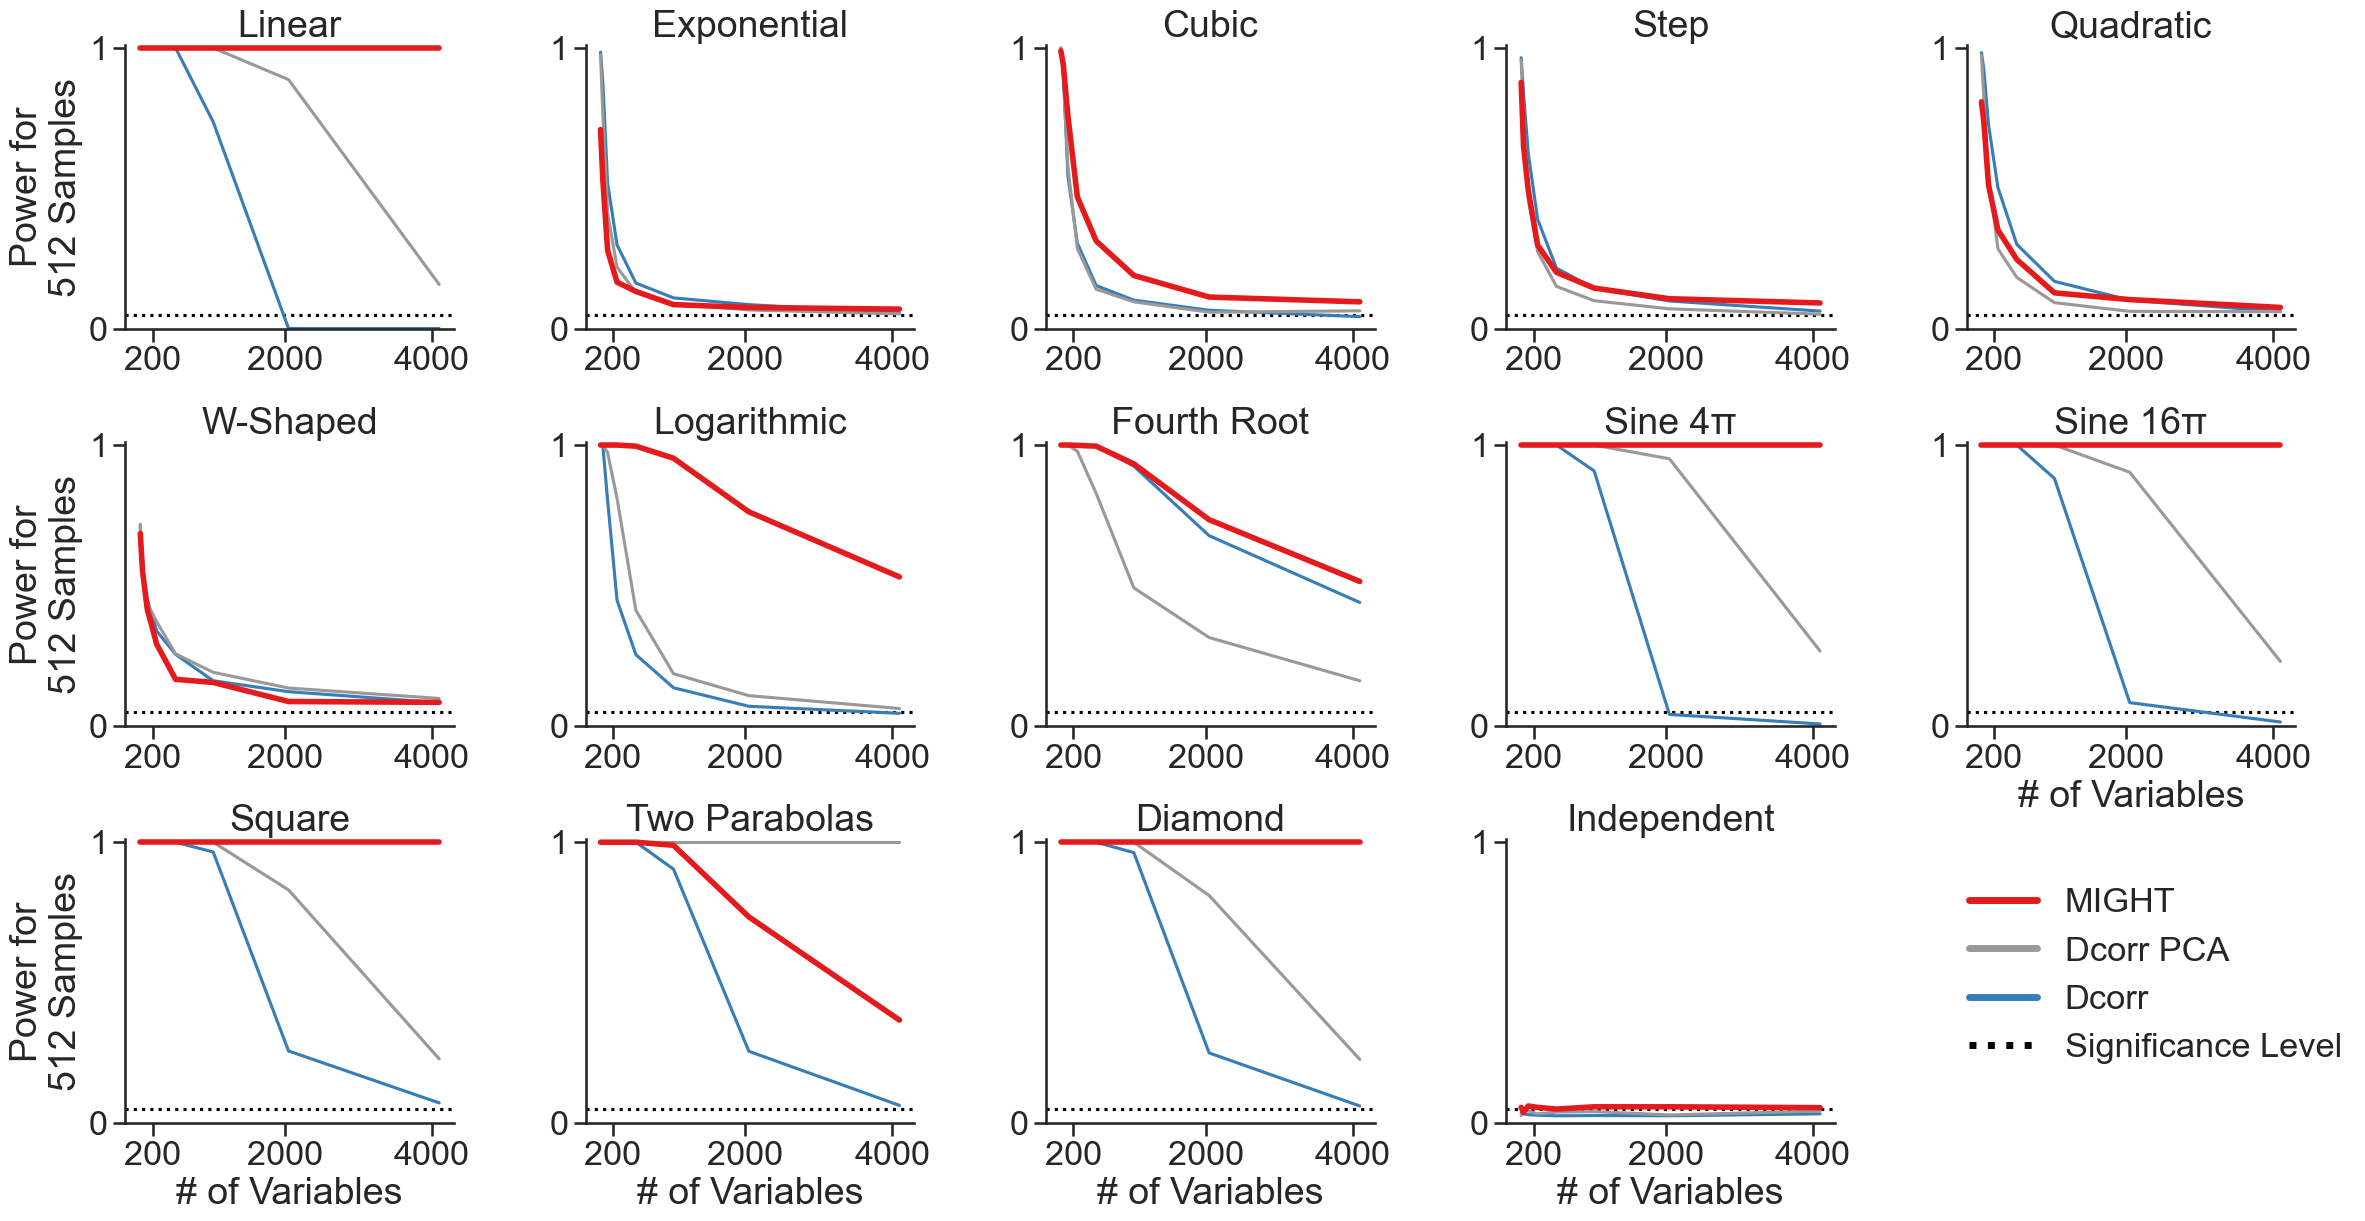

In [9]:
ALPHA = 0.05
FIG_REPS = 1000
NROWS, NCOLS = 3, 5
PLOT_KWARGS = {
    "Dcorr" : {"color" : "#377eb8"},
    "Dcorr_PCA" : {"color" : "#999999"},
    "MIGHT" : {"color" : "#e41a1c", "lw" : 4},
    "MIGHT-sktree" : {"color" : "#e41a1c", "lw" : 4, "linestyle" : "--"},
    "MIGHT-Coleman" : {"color" : "#e41a1c", "lw" : 4, "linestyle" : ":"},
}

fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(28, 14))

for i, row in enumerate(ax):
    for j, col in enumerate(row):
        count = NCOLS * i + j

        if count != 14:
            col.axhline(y=0.05, linestyle=":", color="#000000", label="Significance Level")
            for test_key in list(TESTS.keys()):
                test_name = test_key.replace("_", " ")
    
                sim_name = list(SIMULATIONS.keys())[count]
    
                title = SIMULATIONS[sim_name]
                power = []
                for dim in DIMENSIONS:
                    file_name = "{}/{}_{}_{}".format(SAVE_PATH, sim_name, test_key, dim)
                    if test_key in ["MIGHT", "MIGHT-sktree"]:
                        alt_dist, null_dist = map(
                            np.float64,
                            zip(*[
                                np.genfromtxt("{}_{}.txt".format(file_name, rep))
                                for rep in range(FIG_REPS)
                            ]),
                        )
                        cutoff = np.sort(null_dist)[math.ceil(FIG_REPS * (1 - ALPHA)) - 1]
                        empirical_power = (1 + (alt_dist >= cutoff).sum()) / (1 + FIG_REPS)
                    else:
                        pvals = np.array([
                            np.genfromtxt("{}_{}.txt".format(file_name, rep))
                            for rep in range(FIG_REPS)
                        ])
                        empirical_power = (1 + (pvals <= ALPHA).sum()) / (1 + FIG_REPS)
                    power.append(empirical_power)
                
                # print(power)
                col.plot(DIMENSIONS, power, label=test_name, **PLOT_KWARGS[test_key])
            col.set_ylim(0, 1.01)
            col.set_yticks([])
            col.set_xticks([])
            col.set_yticks([0, 1])
            col.set_xticks([200, 2000, 4000])
            if j == 0:
                col.set_ylabel("Power for\n{} Samples".format(SAMP_SIZE * 2))
            if i == NROWS - 1:
                col.set_xlabel("# of Variables")
            if i == NROWS - 2 and j == NCOLS - 1:
                col.set_xlabel("# of Variables")
            col.set_title(title)
            sns.despine(right=True)
        else:
            col.set_axis_off()

leg = row[0].legend(
    bbox_to_anchor=(0.85, 0.3),
    bbox_transform=plt.gcf().transFigure,
    ncol=1,
    loc="upper center",
    reverse=True
)
leg.get_frame().set_linewidth(0.0)
for legobj in leg.legend_handles:
        legobj.set_linewidth(5.0)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.savefig(FIG_PATH + '/all_power_dimension.svg', transparent=True, bbox_inches='tight')